# Rydberg back-end workflow demonstration

In cold atoms, we can also work with Rydberg atoms trapped in optical tweezers. This approach is widely used in companies like QuEra, Pasqal or AtomComputing.

As an example, we implemented here the operation such a tweezer array as it is implemented in various labs around the world. In this notebook we present the control with the API. The communication with the backend happens through the four url endpoints:

1. '.../api/v2/rydberg/get_config/' 
2. '.../api/v2/rydberg/post_job/'
3. '.../api/v2/rydberg/get_job_status/'
4. '.../api/v2/rydberg/get_job_result/'

An interactive documentation can be also found directly online under the [docs](https://qlued.alqor.io/api/v2/docs).


You can use this tutorial in two ways. For testing of local deployments of `qlued` or the [hosted version](https://qlued.alqor.io) provided by Alqor.

## Optional: Preparation for local deployment

To get started locally you have to:

- Apply any migrations to your local server `python manage.py migrate`
- Start the server in a tab as `python manage.py runserver`
- You created an account and saved the credentials this in the local `credentials.py` file. It should contain a variable entry called `username` and one called `password`.

## Get the configuration

In a first step, we will try to see what are the available backends and what are the capabilities.
 This can be done through the json API endpoints `get_config` and `backends`
 

In [1]:
import requests
import json
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

This imports the `credentials_v2.py` file that contains the values of `username` and `token`. They were exported from this notebook for security reasons.

In [2]:
from credentials_v2 import username, token

In [3]:
# for local deployment uncomment the following line
# host_url = 'http://localhost:8000/'

# for work with the cloud version uncomment the following line
host_url = "https://qlued.alqor.io/"

Let us get the general configuration of all the backends first, to find the Rydberg back-end.

In [4]:
url = host_url + "api/v2/backends"
r = requests.get(url)
pprint(r.json())

[{'backend_name': 'alqor_fermionic_tweezer_simulator',
  'backend_version': '0.0.1',
  'basis_gates': ['fhop', 'fint', 'fphase'],
  'cold_atom_type': 'fermion',
  'conditional': False,
  'coupling_map': 'linear',
  'description': 'simulator of a fermionic tweezer hardware. The even wires '
                 'denote the occupations of the spin-up fermions and the odd '
                 'wires denote the spin-down fermions',
  'display_name': 'fermions',
  'dynamic_reprate_enabled': False,
  'gates': [{'coupling_map': [[0, 1, 2, 3],
                              [2, 3, 4, 5],
                              [4, 5, 6, 7],
                              [0, 1, 2, 3, 4, 5, 6, 7]],
             'description': 'hopping of atoms to neighboring tweezers',
             'name': 'fhop',
             'parameters': ['j_i'],
             'qasm_def': '{}'},
            {'coupling_map': [[0, 1, 2, 3, 4, 5, 6, 7]],
             'description': 'on-site interaction of atoms of opposite spin '
                

As we go through the output above we can see that the last backend is the Rydberg simulator, we would like to use through out the rest of this tutorial. We can also get the configuration of this backend specifically through the endpoint `get_config` and the `display_name`.

In [5]:
url_prefix = host_url + "api/v2/rydberg/"
url = url_prefix + "get_config"
pprint(url)
r = requests.get(url)
pprint(r.json())

'https://qlued.alqor.io/api/v2_beta/rydberg/get_config'
{'backend_name': 'alqor_rydberg_simulator',
 'backend_version': '0.0.1',
 'basis_gates': ['rx', 'rz', 'cblock', 'ufull'],
 'cold_atom_type': 'spin',
 'conditional': False,
 'coupling_map': 'linear',
 'description': 'A chain of qubits realized through Rydberg atoms.',
 'display_name': 'rydberg',
 'dynamic_reprate_enabled': False,
 'gates': [{'coupling_map': [[0], [1], [2], [3], [4]],
            'description': 'Evolution under RX',
            'name': 'rx',
            'parameters': ['omega'],
            'qasm_def': 'gate rx(omega) {}'},
           {'coupling_map': [[0], [1], [2], [3], [4]],
            'description': 'Evolution under the RZ gate',
            'name': 'rz',
            'parameters': ['delta'],
            'qasm_def': 'gate rz(delta) {}'},
           {'coupling_map': [[0, 1, 2, 3, 4]],
            'description': 'Apply the Rydberg blockade over the whole array',
            'name': 'cblock',
            'parameters

The above json gives us all kind of information on the backend, quite importantly also the gates that we can work with and their limitations. As we can see the backend implements the following gates:
 
 - `rx` which applies a $x$ local rotation to the qubit.
 - `rz` which applies a $x$ local rotation to the qubit.
 - `cblock` which describes interactions between rydberg atoms.
 - `measure` which reads out the occupation.
 
 More information about the source code can be found [here](https://alqor-ug.github.io/sqooler/rydberg/).

## Deploying a first gate: RX

We will now start with a local $x$ rotation. We have to set up the `json` dictionary that contains all the required information:

- One experiment.
- We perform a $\pi$ pulse on wire zero.
- We read it out.
- We perform only four shots and we run the simulator with two wires of the five allowed wires.


In [7]:
job_payload = {
    "experiment_0": {
        "instructions": [
            ("rx", [0], [np.pi]),
            ("measure", [0], []),
        ],
        "num_wires": 2,
        "shots": 4,
        "wire_order": "sequential",
    },
}

Now, that we set up the instruction, we can submit it via the `post_job` endpoint.

In [8]:
url = url_prefix + "post_job"

pprint(url)
job_response = requests.post(
    url,
    json={"job": json.dumps(job_payload), "username": username, "token": token},
)
job_id = (job_response.json())["job_id"]
print(job_response.json())

'https://qlued.alqor.io/api/v2_beta/rydberg/post_job'
{'job_id': '20230401_091235-rydberg-fred-c9ee3', 'status': 'INITIALIZING', 'detail': 'Got your json.', 'error_message': 'None'}


The simulator has now put the job into the queue and we will have to wait until the calculation is finished. To see its test the job status through `get_job_status`.

In [10]:
url = url_prefix + "get_job_status"

status_response = requests.get(
    url, params={"job_id": job_id, "username": username, "token": token}
)

print(status_response.text)

{"job_id": "20230401_091235-rydberg-fred-c9ee3", "status": "DONE", "detail": "None; Passed json sanity check; Compilation done. Shots sent to solver.", "error_message": "None"}


As we can see the job is finished, so let us see the results the `get_job_result` endpoint.

In [11]:
url = url_prefix + "get_job_result"

result_response = requests.get(
    url, params={"job_id": job_id, "username": username, "token": token}
)

pprint(result_response.json())

{'backend_name': 'alqor_rydberg_simulator',
 'backend_version': '0.0.1',
 'header': {},
 'job_id': '20230401_091235-rydberg-fred-c9ee3',
 'qobj_id': None,
 'results': [{'data': {'memory': ['1', '1', '1', '1']},
              'header': {'extra metadata': 'text', 'name': 'experiment_0'},
              'shots': 4,
              'success': True}],
 'status': 'finished',
 'success': True}


As expected, we obtained the same result for all shots. Let's move on to the more interesting case of a Rabi oscillation.

## Rabi oscillation

In the Rabi oscillation, we actually perform the following series of experiments:

- We create a number of experiments called `experiment_XX`.
- Each one applies a $\pi$ pulse of a different length `phase[ii]`.
- We perform 9 shots for each pulse.

In [12]:
n_phases = 11  # number of phases we would like to investigate
phases = np.linspace(0, 2 * np.pi, n_phases)  # array of phases
job_payload = {}

for ii in range(n_phases):
    exp_str = "experiment_" + str(ii)
    dummy_exp = {
        "instructions": [
            ("rx", [0], [phases[ii]]),
            ("measure", [0], []),
            ("measure", [1], []),
        ],
        "num_wires": 2,
        "shots": 9,
    }
    job_payload[exp_str] = dummy_exp
pprint(job_payload)

{'experiment_0': {'instructions': [('rx', [0], [0.0]),
                                   ('measure', [0], []),
                                   ('measure', [1], [])],
                  'num_wires': 2,
                  'shots': 9},
 'experiment_1': {'instructions': [('rx', [0], [0.6283185307179586]),
                                   ('measure', [0], []),
                                   ('measure', [1], [])],
                  'num_wires': 2,
                  'shots': 9},
 'experiment_10': {'instructions': [('rx', [0], [6.283185307179586]),
                                    ('measure', [0], []),
                                    ('measure', [1], [])],
                   'num_wires': 2,
                   'shots': 9},
 'experiment_2': {'instructions': [('rx', [0], [1.2566370614359172]),
                                   ('measure', [0], []),
                                   ('measure', [1], [])],
                  'num_wires': 2,
                  'shots': 9},
 'experimen

Time to submit, test the job status and obtain the results.

In [13]:
url = url_prefix + "post_job"

pprint(url)
job_response = requests.post(
    url,
    json={"job": json.dumps(job_payload), "username": username, "token": token},
)
job_id = (job_response.json())["job_id"]
print(job_response.json())

'https://qlued.alqor.io/api/v2_beta/rydberg/post_job'
{'job_id': '20230401_091320-rydberg-fred-b9edf', 'status': 'INITIALIZING', 'detail': 'Got your json.', 'error_message': 'None'}


In [14]:
url = url_prefix + "get_job_status"

status_response = requests.get(
    url, params={"job_id": job_id, "username": username, "token": token}
)

print(status_response.text)

{"job_id": "20230401_091320-rydberg-fred-b9edf", "status": "INITIALIZING", "detail": "Got your json.", "error_message": "None"}


In [15]:
url = url_prefix + "get_job_result"
result_response = requests.get(
    url, params={"job_id": job_id, "username": username, "token": token}
)

results_dict = result_response.json()
pprint(results_dict)

{'backend_name': 'alqor_rydberg_simulator',
 'backend_version': '0.0.1',
 'header': {},
 'job_id': '20230401_091320-rydberg-fred-b9edf',
 'qobj_id': None,
 'results': [{'data': {'memory': ['0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0']},
              'header': {'extra metadata': 'text', 'name': 'experiment_0'},
              'shots': 9,
              'success': True},
             {'data': {'memory': ['0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0',
                                  '1 0',
                                  '0 0',
                                  '0 0',
            

and make the results pretty

In [16]:
measurements = []
for res in results_dict["results"]:
    shots = np.array(res["data"]["memory"])
    shots = [shot.split(" ") for shot in shots]
    # print(shots.shape)
    for ii, el in enumerate(shots):
        shots[ii] = [int(meas) for meas in el]
    measurements.append(shots)

measurements = np.array(measurements)

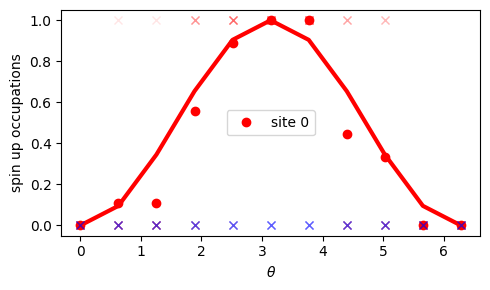

In [17]:
n0s = measurements[:, :, 0]
n1s = measurements[:, :, 1]
f, ax = plt.subplots(figsize=(5, 3))
ax.plot(phases, n0s, "rx", alpha=0.1)
ax.plot(phases, n0s.mean(axis=1), "ro", label="site 0")
ax.plot(phases, (1 - np.cos(phases)) / 2, "r-", lw=3)
ax.plot(phases, n1s, "bx", alpha=0.1)
ax.set_ylabel(r"spin up occupations")
ax.set_xlabel("$\\theta$")
ax.legend()
f.tight_layout()

## Ramsey

We can also test a compination of $RX$ and $RZ$ gate through a Ramsey sequence, which we specify below.

In [18]:
n_phases = 11  # number of phases we would like to investigate
phases = np.linspace(0, 2 * np.pi, n_phases)  # array of phases
job_payload = {}

for ii in range(n_phases):
    exp_str = "experiment_" + str(ii)
    dummy_exp = {
        "instructions": [
            ("rx", [0], [np.pi / 2]),
            ("rz", [0], [phases[ii]]),
            ("rx", [0], [np.pi / 2]),
            ("measure", [0], []),
            ("measure", [1], []),
        ],
        "num_wires": 2,
        "shots": 9,
    }
    job_payload[exp_str] = dummy_exp
pprint(job_payload)

{'experiment_0': {'instructions': [('rx', [0], [1.5707963267948966]),
                                   ('rz', [0], [0.0]),
                                   ('rx', [0], [1.5707963267948966]),
                                   ('measure', [0], []),
                                   ('measure', [1], [])],
                  'num_wires': 2,
                  'shots': 9},
 'experiment_1': {'instructions': [('rx', [0], [1.5707963267948966]),
                                   ('rz', [0], [0.6283185307179586]),
                                   ('rx', [0], [1.5707963267948966]),
                                   ('measure', [0], []),
                                   ('measure', [1], [])],
                  'num_wires': 2,
                  'shots': 9},
 'experiment_10': {'instructions': [('rx', [0], [1.5707963267948966]),
                                    ('rz', [0], [6.283185307179586]),
                                    ('rx', [0], [1.5707963267948966]),
                       

In [19]:
url = url_prefix + "post_job"

pprint(url)
job_response = requests.post(
    url,
    json={"job": json.dumps(job_payload), "username": username, "token": token},
)
job_id = (job_response.json())["job_id"]
print(job_response.json())

'https://qlued.alqor.io/api/v2_beta/rydberg/post_job'
{'job_id': '20230401_091410-rydberg-fred-8e43c', 'status': 'INITIALIZING', 'detail': 'Got your json.', 'error_message': 'None'}


In [20]:
url = url_prefix + "get_job_status"

status_response = requests.get(
    url, params={"job_id": job_id, "username": username, "token": token}
)

print(status_response.json())

{"job_id": "20230401_091410-rydberg-fred-8e43c", "status": "INITIALIZING", "detail": "Got your json.", "error_message": "None"}


In [21]:
url = url_prefix + "get_job_result"
result_response = requests.get(
    url, params={"job_id": job_id, "username": username, "token": token}
)

results_dict = result_response.json()
pprint(results_dict)

{'backend_name': 'alqor_rydberg_simulator',
 'backend_version': '0.0.1',
 'header': {},
 'job_id': '20230401_091410-rydberg-fred-8e43c',
 'qobj_id': None,
 'results': [{'data': {'memory': ['1 0',
                                  '1 0',
                                  '1 0',
                                  '1 0',
                                  '1 0',
                                  '1 0',
                                  '1 0',
                                  '1 0',
                                  '1 0']},
              'header': {'extra metadata': 'text', 'name': 'experiment_0'},
              'shots': 9,
              'success': True},
             {'data': {'memory': ['1 0',
                                  '0 0',
                                  '1 0',
                                  '1 0',
                                  '1 0',
                                  '1 0',
                                  '1 0',
                                  '0 0',
            

and make the results pretty

In [22]:
measurements = []
for res in results_dict["results"]:
    shots = np.array(res["data"]["memory"])
    shots = [shot.split(" ") for shot in shots]
    # print(shots.shape)
    for ii, el in enumerate(shots):
        shots[ii] = [int(meas) for meas in el]
    measurements.append(shots)

measurements = np.array(measurements)

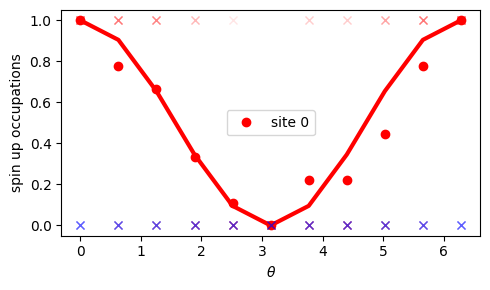

In [23]:
n0s = measurements[:, :, 0]
n1s = measurements[:, :, 1]
f, ax = plt.subplots(figsize=(5, 3))
ax.plot(phases, n0s, "rx", alpha=0.1)
ax.plot(phases, n0s.mean(axis=1), "ro", label="site 0")
ax.plot(phases, (1 + np.cos(phases)) / 2, "r-", lw=3)
ax.plot(phases, n1s, "bx", alpha=0.1)
ax.set_ylabel(r"spin up occupations")
ax.set_xlabel("$\\theta$")
ax.legend()
f.tight_layout()

## Blockade

The most interesting part is the Rydberg blockade. It allows us to entangle the atom, THE ingredient that is nowadays considered crucial for quantum speed-ups. To test it we will reproduce the results of [this early paper](https://www.nature.com/articles/nphys1183), which demonstrate Rydberg blockade first.

In [24]:
n_phases = 11  # number of phases we would like to investigate
phases = np.linspace(0, 2 * np.pi, n_phases)  # array of phases
job_payload = {}

for ii in range(n_phases):
    exp_str = "experiment_" + str(ii)
    dummy_exp = {
        "instructions": [
            ("ufull", [0, 1], [phases[ii], 0, phases[ii] * 1e4 + np.random.rand()]),
            ("measure", [0], []),
            ("measure", [1], []),
        ],
        "num_wires": 2,
        "shots": 12,
    }
    job_payload[exp_str] = dummy_exp
pprint(job_payload)

{'experiment_0': {'instructions': [('ufull',
                                    [0, 1],
                                    [0.0, 0, 0.24172585431257643]),
                                   ('measure', [0], []),
                                   ('measure', [1], [])],
                  'num_wires': 2,
                  'shots': 12},
 'experiment_1': {'instructions': [('ufull',
                                    [0, 1],
                                    [0.6283185307179586, 0, 6283.224188614692]),
                                   ('measure', [0], []),
                                   ('measure', [1], [])],
                  'num_wires': 2,
                  'shots': 12},
 'experiment_10': {'instructions': [('ufull',
                                     [0, 1],
                                     [6.283185307179586, 0, 62832.43604656729]),
                                    ('measure', [0], []),
                                    ('measure', [1], [])],
                   'nu

In [25]:
url = url_prefix + "post_job"

pprint(url)
job_response = requests.post(
    url,
    json={"job": json.dumps(job_payload), "username": username, "token": token},
)
job_id = (job_response.json())["job_id"]
print(job_response.json())

'https://qlued.alqor.io/api/v2_beta/rydberg/post_job'
{'job_id': '20230401_091503-rydberg-fred-f0965', 'status': 'INITIALIZING', 'detail': 'Got your json.', 'error_message': 'None'}


In [26]:
url = url_prefix + "get_job_status"

status_response = requests.get(
    url, params={"job_id": job_id, "username": username, "token": token}
)

print(status_response.text)

{"job_id": "20230401_091503-rydberg-fred-f0965", "status": "DONE", "detail": "None; Passed json sanity check; Compilation done. Shots sent to solver.", "error_message": "None"}


In [27]:
url = url_prefix + "get_job_result"
result_response = requests.get(
    url, params={"job_id": job_id, "username": username, "token": token}
)

results_dict_with_int = result_response.json()
pprint(results_dict_with_int)

{'backend_name': 'alqor_rydberg_simulator',
 'backend_version': '0.0.1',
 'header': {},
 'job_id': '20230401_091503-rydberg-fred-f0965',
 'qobj_id': None,
 'results': [{'data': {'memory': ['0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0']},
              'header': {'extra metadata': 'text', 'name': 'experiment_0'},
              'shots': 12,
              'success': True},
             {'data': {'memory': ['0 0',
                                  '0 0',
                                  '0 0',
                                  '0 0',
                                  '1 0',
           

In [28]:
measurements = []
for res in results_dict_with_int["results"]:
    shots = np.array(res["data"]["memory"])
    shots = [shot.split(" ") for shot in shots]
    # print(shots.shape)
    for ii, el in enumerate(shots):
        shots[ii] = [int(meas) for meas in el]
    measurements.append(shots)

measurements = np.array(measurements)

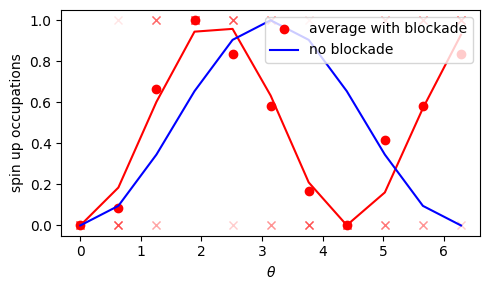

In [29]:
n0s = measurements[:, :, 0]
n1s = measurements[:, :, 1]
n_tot = n0s + n1s
f, ax = plt.subplots(figsize=(5, 3))
ax.plot(phases, n_tot, "rx", alpha=0.1)
ax.plot(phases, n_tot.mean(axis=1), "ro", label="average with blockade")
ax.plot(phases, (1 - np.cos(np.sqrt(2) * phases)) / 2, "r-")
ax.plot(phases, (1 - np.cos(phases)) / 2, "b-", label="no blockade")
ax.set_ylabel(r"spin up occupations")
ax.set_xlabel("$\\theta$")
ax.legend(loc="upper right")
f.tight_layout()